# Initial experiment with GAN-based composition refinement 


In [7]:
import os
COCO_API_DIR = 'D:/Datasets/COCO/cocoapi-master/PythonAPI'
import sys
import threading
import time
sys.path.append('../frontend')
sys.path.append('../backend')
sys.path.append(COCO_API_DIR)

import cv2
import datetime
import pickle
import json
import time
import glob
import timeit
import skimage.io as io
from scipy.ndimage.filters import gaussian_filter
from keras.layers import *
from keras.models import *
from keras import losses
from keras.callbacks import TensorBoard
from keras.optimizers import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random

In [16]:
# This network is going to take the 185-dimensional features and generate part detection and affinity fields
def stage_block(features, 
                prev_block=None, 
                stage_name='KD', 
                num_kernels_per_step=128, 
                num_kernels_out=128,
                num_convs=7, 
                padding='same',
               prefix=''):
    
    if prev_block is not None:
        x = concatenate([features, prev_block],3)
    else:
        x = features
    for i in range(0, num_convs-2):
        x = Conv2D(num_kernels_per_step, 
                   (7,7), 
                   strides=(1,1), 
                   padding=padding, 
                   kernel_initializer='he_uniform', 
                   name='{}Mconv{}_stage{}'.format(prefix,i, stage_name), activation='relu')(x)
        
    x = Conv2D(num_kernels_per_step, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_uniform', name='{}Mconv{}_stage{}'.format(prefix,num_convs-1,stage_name), activation='relu')(x)
    x = Conv2D(num_kernels_out, (1,1), strides=(1,1), padding='valid',kernel_initializer='he_uniform', name='{}Mconv{}_stage{}'.format(prefix,num_convs,stage_name))(x)
    return x

In [94]:
# Load model, steal weights and layers
net = open_pose.get_testing_model()
net.load_weights(OPENPOSE_MODEL_WEIGHTS_PATH)

feat_ = net.layers[28].output
dets_ = net.outputs[1]
paf_ = net.outputs[0]

openpose_out = concatenate([ feat_, paf_, dets_ ], 3)
openpose_model = Model( net.input, openpose_out )

shared_features= Input((46,46,185))

# First tier embedding
embedding_in = stage_block(shared_features, num_kernels_out=185, prefix='emb_')
embedding = embedding_model.embedding_module(embedding_in, embedding_dim=EMBEDDING_DIMENSIONS, mean_shift = False, L2 = False)
emb_model = Model(shared_features, embedding)
#emb_model.load_weights('P:/Machine Learning/Models/Embeddings for OpenPose/20180309_iter_550000_openpose_emb_model_nobg_12chn.h5')
#emb_model.load_weights('P:/Machine Learning/Models/Embeddings for OpenPose/20180309_iter_734000_openpose_emb_model_bg_12chn.h5')
emb_model.load_weights('D:/Machine Learning/LayeredEmbeddings/kickstart/20180309_iter_734000_openpose_emb_model_bg_12chn.h5')
#emb_model.trainable = False
embedding = emb_model(shared_features)


# tri-state mask
#occ_mask = embedding_model.occlusion_mask_module(shared_features)
occ_mask_in = stage_block( shared_features, None,  num_kernels_out=3, prefix='occ_mask_' )
occ_mask = Activation('softmax')(occ_mask_in)
occ_mask_model = Model(shared_features, occ_mask)
# We are using a pre-trained model here baby!
#occ_mask_model.load_weights('P:/Machine Learning/Models/PixelOccupancy on OpenPose/iter_448374_openpose_cls_model.h5')
occ_mask_model.load_weights('D:/Machine Learning/LayeredEmbeddings/kickstart/iter_448374_openpose_cls_model.h5')
#occ_mask_model.trainable = False

# Tensor
occ_mask = occ_mask_model(shared_features)


combined_input = Concatenate(axis = -1)([shared_features, embedding, occ_mask])
#combined_input = Input((46,46,185+EMBEDDING_DIMENSIONS+3))
occ_embedding_in = stage_block( combined_input, None,  num_kernels_out=192, prefix='occ_emb_' )
occ_embedding = embedding_model.occlusion_embedding_module(occ_embedding_in, embedding_dim=EMBEDDING_DIMENSIONS)

final_results = Concatenate(axis = -1)([embedding, occ_mask, occ_embedding])
model = Model(inputs = shared_features, outputs = final_results)





In [113]:
# Pickle stuff
def save_training_example(data_train):
    fname = 'ex_{}.pickle'.format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S'))
    fpath = os.path.join(GENERATED_TRAINING_EXAMPLES_OUTPUT_DIR, fname)
    with open(fpath, 'wb') as file:
        pickle.dump(data_train, file)
    return fpath
        
def load_training_example(fpath):
    with open(fpath, 'rb') as file:
        data_train = pickle.load(file)
        return data_train
    return None

def get_composite_mask(masks, dilation_size=0):
    out = masks[0]*0
    for mask in masks:
        if dilation_size > 0:
            kernel = np.ones((dilation_size,dilation_size), np.uint8)
            mask = cv2.dilate(mask, kernel)
        out = out + np.round(mask)
    return out


def scale_and_pad(image, longer_edge_out=255, pad_value=0, pad_mode='CENTER', scale_mode='max'):
    """Takes an image and rescales it with padding while keeping the ratio intact and putting image in the center or in the top-left corner """
    
    # Checking if the image is 2D or 3D (with channels)
    if(len(image.shape)>2):
        num_channels = image.shape[-1]
        image_scaled_and_padded = np.zeros((longer_edge_out,longer_edge_out,num_channels)) + pad_value
    else:
        num_channels = 1
        image_scaled_and_padded = np.zeros((longer_edge_out,longer_edge_out)) + pad_value

    # Calculate the scale according to the longer edge of image
#    if scale_mode=='min':
#        scale = float(longer_edge_out/ np.min([ image.shape[1], image.shape[0] ]))
#    else:
    scale = float(longer_edge_out/ np.max([ image.shape[1], image.shape[0] ]))        
    image = cv2.resize(image,None, fx=scale, fy=scale)
    if(pad_mode is 'CENTER'):
        shiftyx = (longer_edge_out-np.array(image.shape[0:2]))//2
    else:
        shiftyx = [0,0]
        
    # Put the image in place
    image_scaled_and_padded[shiftyx[0]:shiftyx[0]+image.shape[0], shiftyx[1]:shiftyx[1]+image.shape[1],] = image
    return image_scaled_and_padded, scale, shiftyx


# FIXME: Needs to be moved to untils.py when ready!
def get_augmentation_params(w,h, aug_shift_range=0, aug_rot_range=0, aug_scale_range=None, aug_shear_range=0):
    T = np.zeros((2,3))
    T[0,0] = 1
    T[1,1] = 1
    if aug_scale_range is not None:
        if type(aug_scale_range) is int or type(aug_scale_range) is float:
            s = np.random.uniform(1-aug_scale_range, 1+aug_scale_range, (1,))
        elif type(aug_scale_range) is tuple and len(aug_scale_range) == 2:
            s = np.random.uniform(aug_scale_range[0], aug_scale_range[1], (1,))
        T[0,0] = s
        T[1,1] = s
    
    # FIXME: Add shearing
    R = None
    if aug_shift_range > 0:
        shiftxy = np.random.uniform(-aug_shift_range,aug_shift_range,(2,))
        T += np.float32([[0,0,shiftxy[0]],[0,0,shiftxy[1]]]) # get the translation matrix
    if aug_rot_range != 0:                
        angle_deg = np.random.uniform(-aug_rot_range,aug_rot_range,(1,))[0]
        R = cv2.getRotationMatrix2D((w/2,h/2), angle_deg,1)
    return R, T

def get_image_with_all_meta(gen_train, scale_range=(0.5,1.5), shift_range=0, rot_range=0, scale_mode='min'):
    img_info, keypoints, masks, anns = next(gen_train)
    fpath = os.path.join(COCO_IMAGES_ROOT, img_info['file_name'])
    image_scaled_and_padded, image, scale, shiftyx = load_and_preprocess_image(fpath, longer_edge_out=longer_edge_resize)
    image_rect = scale_and_pad( np.array(image[:,:,0]*0+1), longer_edge_out=longer_edge_resize, scale_mode=scale_mode  )[0]
    masks = [scale_and_pad(masks[i], longer_edge_out=longer_edge_resize, scale_mode=scale_mode)[0] for i in range(0,len(masks))]

    # Augmentations
    R = None
    T = None
#    R, T = get_augmentation_params(longer_edge_resize,longer_edge_resize, aug_shift_range=shift_range, aug_rot_range=rot_range, aug_scale_range=scale_range)
#    image_scaled_and_padded = augment(image_scaled_and_padded, T, R)
#    image_rect = augment(image_rect, T, R)
#    masks = [ (augment( masks[i], T,R )>0).astype(np.uint8) for i in range(0, len(masks)) ]

    masks = filter_masks(masks)
    
    if 0:
        print('Number of masks: {}'.format( len(masks) ))
        for mask in masks:
            plt.imshow(mask)
            plt.title('Values: {}'.format(np.unique(mask)))
            plt.show()
    
    
    out = dict()
    out['img_info'] = img_info
    out['keypoints'] = keypoints
    out['masks'] = masks
    out['anns'] = anns
    out['R'] = R
    out['T'] = T
    out['fpath'] = fpath
    out['image_scaled_and_padded'] = image_scaled_and_padded
    out['rect_scaled_and_padded'] = image_rect
    out['image'] = image
    out['scale'] = scale
    out['shiftyx'] = shiftyx
    return out


def extract_dominant_person(I):
    biggest_mask_idx = np.argmax([ np.sum(mask) for mask in I['masks'] ])
    biggest_obj_mask = scale_and_pad(I['masks'][biggest_mask_idx], longer_edge_out=longer_edge_resize, scale_mode='min')[0]
    biggest_obj_mask = (biggest_obj_mask> 0)
    biggest_obj_mask_3chn = np.stack([ biggest_obj_mask,biggest_obj_mask,biggest_obj_mask ], axis=2)
    biggest_obj = np.multiply(I['image_scaled_and_padded'], biggest_obj_mask_3chn)
    return biggest_obj, biggest_obj_mask
    
def generate_integer_mask(masks):
    """ Takes the masks as an output """
    image_edge = masks[0].shape[1]
    mask_out = np.zeros((image_edge, image_edge))
    
    j=1
    for mask in masks:
        mask = np.array(mask>0).astype(np.int32)
        mask_pixels = np.sum( mask )
        if mask_pixels > 30:
            mask = mask*(j)
            mask_out = mask_out*(mask==0) + mask
            j += 1
    
    # mask cleanup
    j=0
    for value in np.unique(mask_out):
        mask_out[ mask_out==value] = j
        j += 1

    return mask_out    

def filter_masks(masks):
    """ Takes the masks as an output """
    image_edge = masks[0].shape[1]
    masks_out = []
    
    for mask in masks:
        mask = np.array(mask>0).astype(np.uint8)
        mask_pixels = np.sum( mask )
        if mask_pixels > 30:
            masks_out.append(mask)
    

    return masks_out   

def get_image_suitable_for_blending_with_meta(gen, scale_range=(0.5,1.5), shift_range=0, rot_range=0, allow_overlaps=True, debug=False):
    mask_area_th = 0.10 # Percentage
    min_visible_kps = 6
    overlap_check_dilation_size = 15
    enforce_kps_vis = ['LShoulder', 'RShoulder', 'LHip', 'RHip']
    
    while 1:
        time_before = time.time()
        IM = get_image_with_all_meta(gen_train, scale_range=scale_range, shift_range=shift_range, rot_range=rot_range) # image with meta
        time_after = time.time()
        timing_sampling = time_after-time_before
        
        
        time_before = time.time()
        # 0. At least one object in the image
        if(len(IM['masks']) == 0):
            if debug:
                print('Image needs to have at least 1 non-empty mask')
            continue
        
        # 1. Dominant object needs to be bigger than X% of the image
        biggest_mask_idx = np.argmax([ np.sum(mask) for mask in IM['masks'] ])
        biggest_mask_area_perc = np.sum(IM['masks'][biggest_mask_idx])/np.prod(IM['masks'][biggest_mask_idx].shape[0:2])
        if biggest_mask_area_perc < mask_area_th:
            if debug:
                print('Object not big enough! {} < {}'.format(biggest_mask_area_perc, mask_area_th))
            continue
    
    
        # 2. Minimum N keypoints visible
        dom_obj_kps = IM['anns'][biggest_mask_idx]['keypoints']
        num_visible_kps = np.sum([ dom_obj_kps[i+2]==2 for i in range(0,len(dom_obj_kps),3) ])
        if(num_visible_kps <min_visible_kps ):
            if debug:
                print('Not enough keypoints are visible!')
            continue
        if 0:
            if debug:
                print('Visible kps: {}'.format(num_visible_kps))
            plt.imshow( IM['masks'][biggest_mask_idx] )
            for i in range(0, len(dom_obj_kps),3):
                plt.plot( dom_obj_kps[i], dom_obj_kps[i+1], 'rx' )
            plt.show()
        
        # 3. Types of keypoints
        # We need to see the following keypoints
        #print(dom_obj_kps)
        kps_vis_pass = True
        for kp_name in enforce_kps_vis:
            i = datasets.KEYPOINT_LABELS_COCO.index(kp_name)
            #print( '{}: {}'.format( kp_name, dom_obj_kps[3*i :3*i+3] ))
            if( dom_obj_kps[3*i + 2] != 2 ):
                if debug:
                    print('{} is not visible!'.format(kp_name))
                kps_vis_pass = False
                break
        if kps_vis_pass is False:
            continue
                
        # 4. No "overlapping" regions
        if allow_overlaps is False:
            comp_mask = get_composite_mask(IM['masks'], dilation_size=overlap_check_dilation_size)
            if np.sum(comp_mask>1) > 0:
                if debug:
                    print('Overlaping object masks exist in the image, skipping')
                continue
        
        timing_per_image_checks = time.time()-time_before
        
        IM['timing_per_image_checks'] = timing_per_image_checks
        IM['timing_sampling'] = timing_sampling
        
        return IM
    
    

    
    
def get_training_dict_pixel_occ(gen, debug=True):
    erosion_ksize = 3
    erosion_iterations = 3
    smooth_mask_ksize = 3
    overlap_perc_th = 0.8
    max_occ_perc_th = 0.8
    
 
    # Get images A and B
    time_before = time.time()
    A = get_image_suitable_for_blending_with_meta(gen_train, scale_range=(1.0,1.0), shift_range=0, rot_range=0, allow_overlaps=False)
    B = get_image_suitable_for_blending_with_meta(gen_train, scale_range=(1.0,1.0), shift_range=0, rot_range=0, allow_overlaps=False) # we don't care about overlaps here
    

    
    
#    data_train = load_training_example(os.path.join(GENERATED_TRAINING_EXAMPLES_OUTPUT_DIR,'ex_20180422230454.pickle'))
#    A = data_train['A']
#    B = data_train['B']

    
    B_person, B_person_mask = extract_dominant_person(B)

    timing_images_sampling = time.time() - time_before
    
    # Composite images
    # Adding nincer blending Apr 6 2018
    
    # B-mask erosion
#    kernel = np.ones((erosion_ksize,erosion_ksize),np.uint8)
#    B_person_mask = cv2.erode(B_person_mask.astype(np.float32), kernel, iterations=erosion_iterations)
    
    # B-mask smoothing
#    kernel = np.ones((smooth_mask_ksize,smooth_mask_ksize),np.float32)/(smooth_mask_ksize*smooth_mask_ksize)
#    B_person_mask = cv2.filter2D(B_person_mask.astype(np.float32),-1,kernel).astype(np.float32)

    if 0:
        plt.imshow(A['image_scaled_and_padded'].astype(np.uint8))
        plt.show()

        plt.imshow(np.multiply(B['image_scaled_and_padded'], np.stack([ B_person_mask,B_person_mask,B_person_mask ], axis=2)).astype(np.uint8))
        plt.show()

    
    if 0:
        plt.imshow(B_person_mask)
        plt.show()
        plt.imshow(B_person_mask_smooth)
        plt.show()
        print('Smooth mask: {} to {}'.format( B_person_mask_smooth.min(), B_person_mask_smooth.max() ))
    
    
    img = np.multiply(A['image_scaled_and_padded'], np.stack([ 1-B_person_mask,1-B_person_mask,1-B_person_mask ], axis=2)) + \
            np.multiply(B['image_scaled_and_padded'], np.stack([ B_person_mask,B_person_mask,B_person_mask ], axis=2))

    if 0:
        plt.imshow(A['rect_scaled_and_padded'].astype(np.uint8))
        plt.show()
        
    masks = [ np.copy(mask) for mask in  A['masks'] ] 
    masks.append(  B_person_mask  )
    
    composite_mask = get_composite_mask(masks)

    # Heuristic: No mask can be occluded more than 100%
    for mask in A['masks']:
        mask_occ_perc = np.sum( mask*(composite_mask>1))/np.sum(mask>0)
        if mask_occ_perc > max_occ_perc_th:
            if debug:
                print('One of the objects is {}% occluded!'.format(100*mask_occ_perc))
            return None
        if 0:
            plt.subplot(1,2,1)
            plt.imshow( mask )
            plt.subplot(1,2,2)
            plt.imshow(composite_mask)
            plt.title('Occlusion perc: {}'.format(mask_occ_perc))
            plt.show()
    
    if 0:
        # Heuristic: Finding the overlap
        overlap_perc = np.sum(composite_mask>1)/np.sum( composite_mask>0)
        if overlap_perc > overlap_perc_th:
            if debug:
                print('Overlap per too high: {}'.format(overlap_perc))
            return None
    
    # 3 classes: 0-background, 1-single object, 2-more than 1 object occupying this pixel, start with all zeros
    gt = np.zeros((composite_mask.shape[0], composite_mask.shape[1], 3))
    gt[:,:,0] = composite_mask==0
    gt[:,:,1] = composite_mask==1
    gt[:,:,2] = composite_mask>1
    
    #print('Unique values in composite mask: {}'.format(np.unique(composite_mask)))

    occ_mask = (composite_mask>1)
    
    occ_mask_out = A['masks'][0]*0
    i=1
    for mask in A['masks']:
        # if not fully occluded:
        num_viz_pixels = np.sum(np.multiply(mask, 1-gt[:,:,2]))
        if 0:
            print('Object ID: {} number of visible pixels: {}'.format(i,num_viz_pixels ))
            plt.imshow(mask)
            plt.show()
            plt.imshow(1-gt[:,:,2])
            plt.show()
            
        if num_viz_pixels > 0:
            partial = (np.multiply( i*(mask>0) , occ_mask)).astype(np.uint8)
            if 0:
                plt.imshow(partial)
                plt.title('Partial occ mask {}\n values:{}'.format(i, np.unique(partial)))
                plt.show()
            occ_mask_out += partial
            
        i+=1
    
    if 0:
        plt.imshow(occ_mask_out)
        plt.title('Occlusion mask\n values{}'.format(np.unique(occ_mask_out)))
        plt.show()
    
    gt_enable = (A['rect_scaled_and_padded']>0).astype(np.float32)

    
    if 0:
        plt.imshow(img.astype(np.uint8))
        plt.show()

    if 0:
        plt.imshow(A['image_scaled_and_padded'].astype(np.uint8))
        plt.show()
        plt.imshow(B['image_scaled_and_padded'].astype(np.uint8))
        plt.show()
    
    # generate output
    out = dict()
    out['A'] = A
    out['B'] = B
    out['inserted'] = np.multiply(B['image_scaled_and_padded'], np.stack([ B_person_mask,B_person_mask,B_person_mask ], axis=2))
#    out['x'] = openpose_model.predict(np.expand_dims(img, 0))
    out['y'] = np.expand_dims(gt[::8,::8,:], 0)
    out['occ_mask'] = occ_mask_out[::8,::8]
    out['masks'] = masks
    out['pixelid'] = generate_integer_mask(masks)[::8,::8]
    out['masks_small'] = [ mask[::8,::8] for mask in masks ]
    out['y_training_enable_mask'] = gt_enable[::8,::8]
    out['image_scaled_and_padded'] = img
    return out


data_train = get_training_dict_pixel_occ(gen_train)





Timing:
 Sampling and compoisition: 1.2599918842315674
 Example storage: 0.0 
 Openpose: 0.18400073051452637 
 10 iterations take: 14.134010553359985


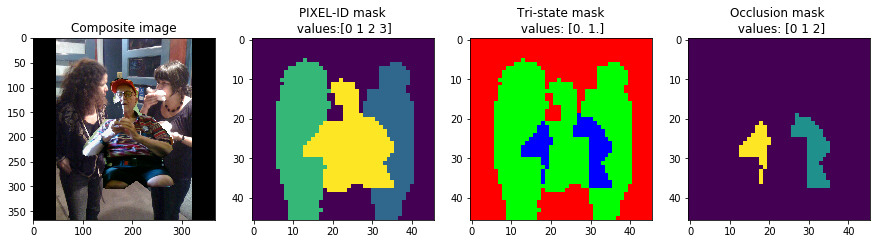

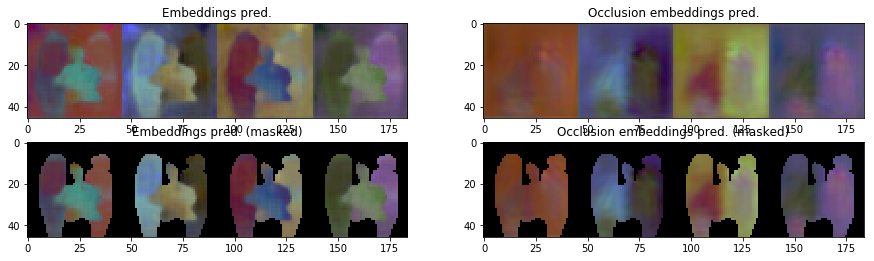

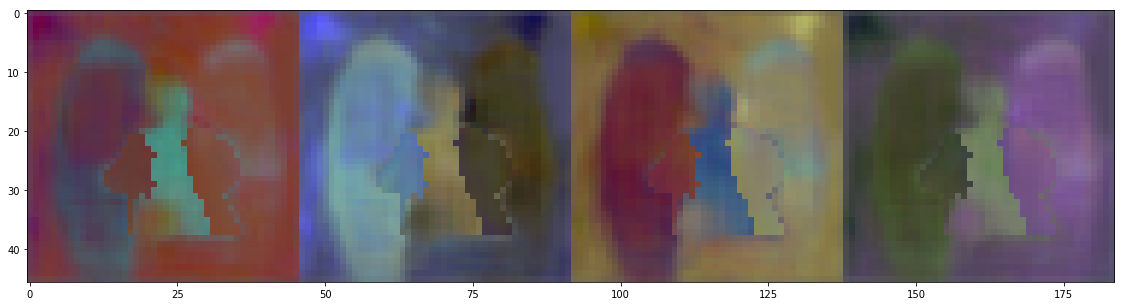

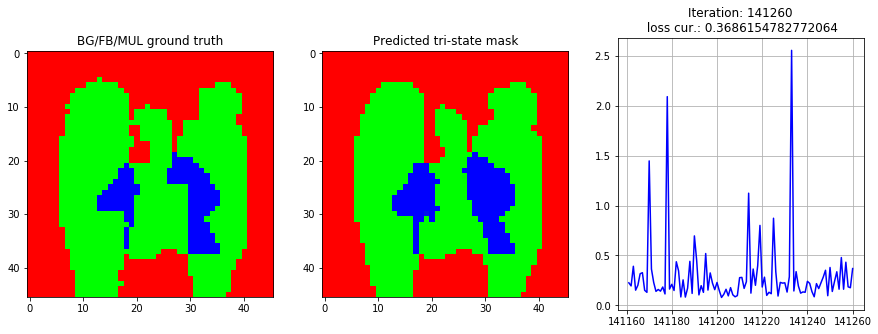

y_true_w shape: (1, 46, 46, 1)
Y true mask shape: (1, 46, 46, 1)
Y true tri state mask shape: (1, 46, 46, 3)
Y occlusion mask shape: (1, 46, 46, 1)
X shape: (1, 46, 46, 185)
Y shape: (1, 46, 46, 7)
Epoch 1/1
1/1 [==============================] - 0s 131ms/step - loss: 0.1362
y_true_w shape: (1, 46, 46, 1)
Y true mask shape: (1, 46, 46, 1)
Y true tri state mask shape: (1, 46, 46, 3)
Y occlusion mask shape: (1, 46, 46, 1)
X shape: (1, 46, 46, 185)
Y shape: (1, 46, 46, 7)
Epoch 1/1
1/1 [==============================] - 0s 129ms/step - loss: 0.1938
y_true_w shape: (1, 46, 46, 1)
Y true mask shape: (1, 46, 46, 1)
Y true tri state mask shape: (1, 46, 46, 3)
Y occlusion mask shape: (1, 46, 46, 1)
X shape: (1, 46, 46, 185)
Y shape: (1, 46, 46, 7)
Epoch 1/1
1/1 [==============================] - 0s 129ms/step - loss: 0.0551
y_true_w shape: (1, 46, 46, 1)
Y true mask shape: (1, 46, 46, 1)
Y true tri state mask shape: (1, 46, 46, 3)
Y occlusion mask shape: (1, 46, 46, 1)
X shape: (1, 46, 46, 185

KeyboardInterrupt: 

In [114]:

# Pre-generated examples
#ex_fpaths = glob.glob(os.path.join(GENERATED_TRAINING_EXAMPLES_OUTPUT_DIR, 'ex_*.pickle'))

#fpath = os.path.join(GENERATED_TRAINING_EXAMPLES_OUTPUT_DIR, 'ex_20180422111749.pickle')
show_every_n_iterations = 10
running = True
timer_modulo_start = 0
verify_frozen_weights = False
while running:

#    ex_idx = int(np.random.uniform(0,len(ex_fpaths), (1,))[0])
#    with open(fpath, 'rb') as ex_file:
#        data_train = pickle.load(ex_file)

    time_before = time.time()
    data_train = get_training_dict_pixel_occ(gen_train)
    time_after = time.time()
    timing_sampling_and_composition = (time_after-time_before)
#    data_train = load_training_example(os.path.join(GENERATED_TRAINING_EXAMPLES_OUTPUT_DIR,'ex_20180422230454.pickle'))

    
    if data_train is None:
        print('Skipping...')
        continue

    time_before = time.time()
#    saved_example_fpath = save_training_example(data_train)
    timing_example_storage = time.time() - time_before

    time_before = time.time()
    x = openpose_model.predict(np.expand_dims( data_train['image_scaled_and_padded'] , 0))
    timing_openpose = time.time() - time_before
    
    
    # Bogus y_true:
    y_true_w = np.expand_dims(np.expand_dims(data_train['y_training_enable_mask'],0),3)
    y_true_mask = np.expand_dims(np.expand_dims(data_train['pixelid'], 0),3).astype(np.uint8)
    y_true_tri_state_mask = data_train['y']
    y_true_occ_mask = np.expand_dims(np.expand_dims(data_train['occ_mask'], 0),3).astype(np.uint8)
    
    
    # Let's do some check here to make sure we are not producing bad inputs
    if(len(np.unique(y_true_mask)) != 1+np.max(y_true_mask)):
        print('WRONG PIXEL-ID INPUT!!!!')
        continue
    
    
    print('y_true_w shape: {}'.format(y_true_w.shape))
    print('Y true mask shape: {}'.format(y_true_mask.shape))
    print('Y true tri state mask shape: {}'.format(y_true_tri_state_mask.shape))
    print('Y occlusion mask shape: {}'.format(y_true_occ_mask.shape))
    
    y = np.concatenate([ y_true_w, y_true_mask, y_true_tri_state_mask, y_true_occ_mask, y_true_occ_mask ], axis=3)
    
        
    print('X shape: {}'.format(x.shape))
    print('Y shape: {}'.format(y.shape))

    model_full_before = model.predict(x)
    emb_model_pred_before = emb_model.predict(x)
    occ_mask_model_pred_before = occ_mask_model.predict( x )
    
    
    # Training the full model
    fit_out = model.fit(x, y)
    
    if verify_frozen_weights:
        occ_mask_model_pred_after = occ_mask_model.predict( x )
        emb_model_pred_after = emb_model.predict(x)
        model_full_after = model.predict(x)
    
    
    
    loss_cur = fit_out.history['loss'][0]
    progress.append([ it, loss_cur ])

    if np.isnan(loss_cur):
        print('GOT A NAN!!!!')
        running = False
#        print('Example {} caused it'.format(saved_example_fpath))
#        break
    #    model.load_weights(os.path.join(MODEL_OUTPUT_DIR, MODEL_OUTPUT_FILE))
    
    if it % show_every_n_iterations == 0:
        timer_modulo_took = time.time()-timer_modulo_start
        timer_modulo_start = time.time()
        
        clear_output()
        
        if verify_frozen_weights:
            print('Assessment of freezing ')
            print('Difference tristate: {}'.format(np.sum(np.abs( occ_mask_model_pred_before-occ_mask_model_pred_after ))))
            print('Difference embedding: {}'.format(np.sum(np.abs( emb_model_pred_after-emb_model_pred_before ))))
            print('Difference full: {}'.format(np.sum(np.abs( model_full_after-model_full_before ))))
        
        
        
        print('Timing:\n Sampling and compoisition: {}\n Example storage: {} \n Openpose: {} \n {} iterations take: {}'.format(timing_sampling_and_composition, timing_example_storage, timing_openpose, show_every_n_iterations, timer_modulo_took))
        
        # Run prediction
        pred = model.predict( x )

        # Composite images for BG / FG for vis
        img_gt = data_train['y'][0]
        img_pred = pred[0]

        
        
        plt.figure(figsize=(15,4))
        plt.subplot(1,4,1)
        plt.imshow(data_train['image_scaled_and_padded'].astype(np.uint8))
        plt.title('Composite image')
#        plt.subplot(1,5,2)
#        plt.imshow(y_true_w[0,:,:,0])
#        plt.title('Training enabled mask (w)\n values:{}'.format(np.unique(y_true_w)))
        plt.subplot(1,4,2)
        plt.imshow(y_true_mask[0,:,:,0])
        plt.title('PIXEL-ID mask\n values:{}'.format(np.unique(y_true_mask)))
        plt.subplot(1,4,3)
        plt.imshow(y_true_tri_state_mask[0])
        plt.title('Tri-state mask\n values: {}'.format(np.unique(y_true_tri_state_mask[0])))
        plt.subplot(1,4,4)
        plt.imshow(y_true_occ_mask[0,:,:,0])
        plt.title('Occlusion mask \n values: {}'.format(np.unique(y_true_occ_mask)))
        plt.show()

        
        
        
        pred_emb = pred[:,:,:,:EMBEDDING_DIMENSIONS]
        pred_occ_emb = pred[:,:,:,EMBEDDING_DIMENSIONS+3:]

        viz_min = np.min([  np.min(pred_emb), np.min(pred_occ_emb)   ])
        viz_max = np.max([  np.max(pred_emb), np.max(pred_occ_emb)   ])

        pred_tri_state_mask_img = pred[0,:,:,EMBEDDING_DIMENSIONS:EMBEDDING_DIMENSIONS+3]
        
        
        pred_emb_img_mask = np.stack([np.concatenate([ 1-pred_tri_state_mask_img[:,:,0]  ]*4, 1)]*3, 2)

        
        pred_emb_img = local_visualize_embeddings(pred_emb, norm_min=viz_min, norm_max=viz_max)
        pred_occ_emb_img = local_visualize_embeddings(pred_occ_emb, norm_min=viz_min, norm_max=viz_max)
        pred_occ_emb_img_masked = np.multiply(pred_occ_emb_img, pred_emb_img_mask)
        pred_emb_img_masked = np.multiply(pred_emb_img, pred_emb_img_mask)
        
        occ_area_mask = pred_tri_state_mask_img[:,:,2]>0.5
        occ_area_mask_row = np.concatenate([ np.stack([occ_area_mask]*3,axis=2) ]*4, axis=1)
        b = 255*(np.multiply(pred_occ_emb_img, occ_area_mask_row) + np.multiply(pred_emb_img, 1-occ_area_mask_row))

        
        plt.figure(figsize=(15,4))
        plt.subplot(2,2,1)
        plt.imshow( pred_emb_img)
        plt.title('Embeddings pred.')
        plt.subplot(2,2,2)
        plt.imshow( pred_occ_emb_img)
        plt.title('Occlusion embeddings pred.')
        plt.subplot(2,2,3)
        plt.imshow( pred_emb_img_masked )
        plt.title('Embeddings pred. (masked)')
        plt.subplot(2,2,4)
        plt.imshow( pred_occ_emb_img_masked)
        plt.title('Occlusion embeddings pred. (masked)')
        plt.show()

        plt.figure(figsize=(20,5))
        plt.imshow(b.astype(np.uint8))
        plt.show()
        
        
        
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow( img_gt )
        plt.title('BG/FB/MUL ground truth')
        plt.subplot(1,3,2)
        plt.imshow(pred_tri_state_mask_img)
        plt.title('Predicted tri-state mask')
        
        plt.subplot(1,3,3)
        p = np.array(progress)
        start = np.max([0, p.shape[0]-100])
        plt.plot( p[start:,0], p[start:,1], 'b-' )
        plt.grid()
        plt.title('Iteration: {}\n loss cur.: {}'.format( it, loss_cur ))
        plt.show()  
        
        
        if it % 100 == 0:
            print('Saving the model')
            model.save(os.path.join(MODEL_OUTPUT_DIR, MODEL_OUTPUT_FILE))

        if it % 1000 == 0:
            fname = 'iter_{}_{}'.format(it, MODEL_OUTPUT_FILE)
            model.save(os.path.join(MODEL_OUTPUT_DIR, fname))

        
    it += 1
    
   

In [117]:
model.save(os.path.join(MODEL_OUTPUT_DIR, '20180425_emb_mask_occ_141266_kickstart.h5'))

In [116]:
print(it)
print(MODEL_OUTPUT_DIR)

141266
D:/Machine Learning/LayeredEmbeddings/trained


In [ ]:
for chn in range(0,pred_occ_emb.shape[3]):
    m = pred_occ_emb[0,:,:,chn]
    
    plt.imshow(m)
    plt.title(' Min: {}, Max: {} '.format(np.min(m), np.max(m)))
    plt.show()
    
    

In [ ]:
A = data_train['A']
gt = data_train['y']

occ_mask_out = A['masks'][0]*0
i=1
for mask in A['masks']:
    # if not fully occluded:
    num_viz_pixels = np.sum(np.multiply(mask, 1-gt[:,:,2]))
    print('Object ID: {} number of visible pixels: {}'.format(i,num_viz_pixels ))
    plt.imshow(mask)
    plt.show()

    plt.imshow(1-gt[:,:,2])
    plt.show()
    if num_viz_pixels > 0:
        partial = (np.multiply( i*(mask>0) , occ_mask)).astype(np.uint8)
        plt.imshow(partial)
        plt.title('Partial occ mask {}\n values:{}'.format(i, np.unique(partial)))
        plt.show()
        occ_mask_out += partial

    i+=1

In [ ]:
for mask in masks:
    a = np.sum(np.multiply(mask, 1-tri_state_mask[:,:,2]))>5
    print(a)


In [ ]:



img = generate_integer_mask( data_train['masks']  )

plt.imshow(data_train['A']['image_scaled_and_padded'].astype(np.uint8))
plt.show()
plt.imshow(data_train['inserted'].astype(np.uint8))
plt.show()
plt.imshow(img)
plt.show()


In [ ]:
fname = 'iter_{}_{}'.format(it, MODEL_OUTPUT_FILE)
model.save(os.path.join(MODEL_OUTPUT_DIR, fname))

In [ ]:
pred_emb = pred[:,:,:,:EMBEDDING_DIMENSIONS]
pred_occ_emb = pred[:,:,:,EMBEDDING_DIMENSIONS+3:]
pred_tri_state_mask_img = pred[0,:,:,EMBEDDING_DIMENSIONS:EMBEDDING_DIMENSIONS+3]
pred_emb_img = visualize_embeddings(pred_emb)

pred_emb_img_mask = np.stack([np.concatenate([ 1-pred_tri_state_mask_img[:,:,0]  ]*4, 1)]*3, 2)
pred_emb_img_masked = np.multiply(pred_emb_img, pred_emb_img_mask)
pred_occ_emb_img = visualize_embeddings(pred_occ_emb)
pred_occ_emb_img_masked = np.multiply(pred_occ_emb_img, pred_emb_img_mask)

a = np.stack([pred_emb_img, pred_emb_img_masked], 0) 
print(a.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow( np.concatenate([pred_emb_img, pred_emb_img_masked], 0) )
plt.title('Embeddings')
plt.subplot(1,2,2)
plt.imshow( np.concatenate([pred_occ_emb_img, pred_occ_emb_img_masked], 0) )
plt.title('Occlusion embeddings')
plt.show()